In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
cd gdrive/MyDrive/Colab Notebooks/VIDEO_ANALYSIS

In [ ]:
import pandas as pd
df = pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

df = df.replace('\n','', regex=True)
df.head()

,Transcript,Sentiment
0,BUT I CAN SAFELY ASSURE YOU THAT EVEN IF THEY...,POSITIVE
1,AND I LOVED IT,POSITIVE
2,I DONT KNOW IF FANS OF THE COMIC WOULD BE AS I...,NEGATIVE
3,BUT JUST GOING INTO THIS A AS AN OBSERVER AND ...,POSITIVE
4,AND I WOULD TELL YOU RIGHT NOW IT WAS HILARIOUS,POSITIVE


In [ ]:
X_train,y_train = df[['Transcript']],df[['Sentiment']]
X_test,y_test = df_test[['Transcript']],df_test['Sentiment']

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 4000) 

# create bag of words vector for the training set using countVectorizer
train_data_features = vectorizer.fit_transform(X_train['Transcript'].values)

# tf-idf transformer initialization
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# create tfidf transformed vector  for the training set using tf-idf transformer
X_train_tfidf = tfidf_transformer.fit_transform(train_data_features)

In [ ]:
test_data_features = vectorizer.transform(X_test['Transcript'].values)
X_test_tfidf = tfidf_transformer.transform(test_data_features)

In [ ]:
import numpy as np

audio_f=[]
labels=[]
j=0
with open('audio_train_features.arff') as f:
    for i in range(140):
        next(f)
    for line in f:
        line=line[:-10]
        v=list(map(float, line.split(",")))
        audio_f.append(v)
        j+=1

In [ ]:
audio_f=np.array(audio_f)
audio_f.shape

(1492, 136)

In [ ]:
import scipy
text_f=X_train_tfidf.toarray()
text_f.shape

(1492, 2437)

In [ ]:
text_test_f=X_test_tfidf.toarray()
text_test_f.shape

(611, 2437)

In [ ]:
import numpy as np

audio_test_f=[]
test_labels=[]
j=0
with open('audio_test_features.arff') as f:
    for i in range(140):
        next(f)
    for line in f:
        line=line[:-10]
        v=list(map(float, line.split(",")))
        audio_test_f.append(v)
        j+=1

In [ ]:
audio_test_f=np.array(audio_test_f)
audio_test_f.shape

(611, 136)

In [ ]:
#Labels

In [ ]:
y_train.shape

(1492, 1)

In [ ]:
y_test.shape

(611,)

VIDEO ANALYSIS

In [ ]:
import numpy as np
import cv2


class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=True, skip=True):
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

In [ ]:
import os
import numpy as np
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,MaxPooling3D)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.layers import ELU

def loaddata(video_dir, vid3d, nclass, color=False, skip=True):
    classes = os.listdir(video_dir)
    print(classes)
    return
    X = []
    labels = []

    for classname in classes:
      files=os.path.join(video_dir,classname)
      for filename in os.listdir(files):
          name = os.path.join(files,filename)
          label = classname
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels

img_rows, img_cols, frames = 112,112,5
channel = 3 #when color=True otherwise it should be 1

vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = 2
x, y = loaddata('/content/gdrive/MyDrive/Colab Notebooks/VIDEO_ANALYSIS/TRAIN', vid3d, nb_classes, True, True)
tx,ty= loaddata('/content/gdrive/MyDrive/Colab Notebooks/VIDEO_ANALYSIS/TEST', vid3d, nb_classes, True, True)
train_X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
test_X=tx.reshape((tx.shape[0], img_rows, img_cols, frames, channel))

In [ ]:
train_X = train_X.astype('float32')
test_X=test_X.astype('float32')

In [ ]:
train_Y=np.array(y)
test_Y=np.array(ty)

In [ ]:
train_X.shape

(1492, 112, 112, 5, 3)

In [ ]:
import keras
print('X_shape:{}\nY_shape:{}'.format(train_X.shape, train_Y.shape))

# Define model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(train_X.shape[1:]), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

optimizer = keras.optimizers.Adam(0.001)
model.summary()

X_shape:(1492, 112, 112, 5, 3)
Y_shape:(1492,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 5, 32)   2624      
_________________________________________________________________
activation (Activation)      (None, 112, 112, 5, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 112, 112, 5, 32)   27680     
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 5, 32)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 38, 38, 2, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 2, 32)     0         
_________________________________________________________________
conv3d_2 

In [ ]:
train_X.shape

(1492, 112, 112, 5, 3)

In [ ]:
train_Y.shape

(1492,)

In [ ]:
test_X.shape

(611, 112, 112, 5, 3)

In [ ]:
test_Y.shape

(611,)

In [ ]:
ntrain_Y=[]
ntest_Y=[]
for i in train_Y:
  if(i=='POSITIVE'):
      ntrain_Y.append(0)
  else:
      ntrain_Y.append(1)

for i in test_Y:
  if(i=='POSITIVE'):
      ntest_Y.append(0)
  else:
      ntest_Y.append(1)

ntrain_Y = np_utils.to_categorical(ntrain_Y, nb_classes)
ntest_Y = np_utils.to_categorical(ntest_Y, nb_classes)

In [ ]:
train_features=model.predict(train_X)
print(train_features.shape)

(1492, 10816)


In [ ]:
test_features=model.predict(test_X)
print(test_features.shape)

(611, 10816)


VIDEO CLASSIFICATION

In [ ]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear') 
  
clf.fit(train_features, train_Y) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
pred=clf.predict(test_features)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_Y,pred))

Text(60.0, 0.5, 'Truth value')

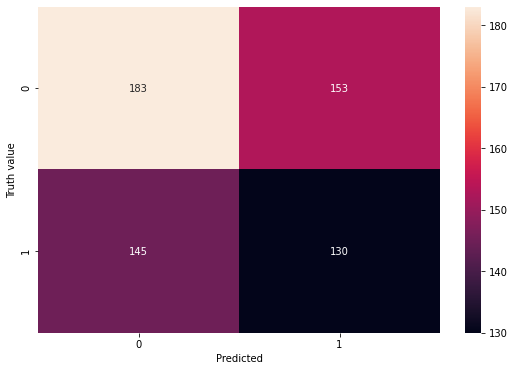

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_Y, pred)

plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

A+V+T FUSION

In [ ]:
from sklearn import svm
from sklearn.decomposition import PCA

#.99 means that we want to include 99% of the variance
pca=PCA(.99)
vid_new_train=pca.fit_transform(train_features)
vid_new_test=pca.transform(test_features)

print(vid_new_train.shape)
print(vid_new_test.shape)

(1492, 535)
(611, 535)


In [ ]:
TRAIN_FUSED_features=np.hstack((text_f,audio_f,vid_new_train))
TRAIN_FUSED_features.shape

(1492, 3108)

In [ ]:
TEST_FUSED_features=np.hstack((text_test_f,audio_test_f,vid_new_test))

In [ ]:
TEST_FUSED_features.shape

(611, 3108)

In [ ]:
#normalization
from sklearn.preprocessing import MinMaxScaler

norm=MinMaxScaler().fit(TRAIN_FUSED_features)

X_train_norm=norm.transform(TRAIN_FUSED_features)
X_test_norm=norm.transform(TEST_FUSED_features)

In [ ]:
from sklearn import svm
from sklearn.decomposition import PCA

#.99 means that we want to include 99% of the variance
pca=PCA(.99)
X_train_pca=pca.fit_transform(X_train_norm)
X_test_pca=pca.transform(X_test_norm)

print(X_train_pca.shape)
print(X_test_pca.shape)


(1492, 1218)
(611, 1218)


In [ ]:
model=svm.SVC(kernel='linear').fit(X_train_pca,y_train)

In [ ]:
predict=model.predict(X_test_pca)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

    NEGATIVE       0.66      0.65      0.66       336
    POSITIVE       0.58      0.59      0.59       275

    accuracy                           0.63       611
   macro avg       0.62      0.62      0.62       611
weighted avg       0.63      0.63      0.63       611



V + T Fusion

In [ ]:
TRAIN_vt_features=np.hstack((text_f,vid_new_train))
TRAIN_vt_features.shape

(1492, 2972)

In [ ]:
TEST_vt_features=np.hstack((text_test_f,vid_new_test))
TEST_vt_features.shape

(611, 2972)

In [ ]:
#normalization
from sklearn.preprocessing import MinMaxScaler

norm=MinMaxScaler().fit(TRAIN_vt_features)

X_train_norm=norm.transform(TRAIN_vt_features)
X_test_norm=norm.transform(TEST_vt_features)

In [ ]:
from sklearn import svm
from sklearn.decomposition import PCA

#.99 means that we want to include 99% of the variance
pca=PCA(.99)
X_train_pca=pca.fit_transform(X_train_norm)
X_test_pca=pca.transform(X_test_norm)

model=svm.SVC(kernel='linear').fit(X_train_pca,y_train)

In [ ]:
predict=model.predict(X_test_pca)

In [ ]:
y_test=np.array(y_test)
y_test.shape

(611,)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

    NEGATIVE       0.67      0.69      0.68       336
    POSITIVE       0.61      0.58      0.59       275

    accuracy                           0.64       611
   macro avg       0.64      0.64      0.64       611
weighted avg       0.64      0.64      0.64       611



A + V fusion

In [ ]:
TRAIN_at_features=np.hstack((audio_f,vid_new_train))
TRAIN_at_features.shape

(1492, 671)

In [ ]:
TEST_at_features=np.hstack((audio_test_f,vid_new_test))
TEST_at_features.shape

(611, 671)

In [ ]:
#normalization
from sklearn.preprocessing import MinMaxScaler

norm=MinMaxScaler().fit(TRAIN_at_features)

X_train_norm=norm.transform(TRAIN_at_features)
X_test_norm=norm.transform(TEST_at_features)

In [ ]:
from sklearn import svm
from sklearn.decomposition import PCA

#.99 means that we want to include 99% of the variance
pca=PCA(.99)
X_train_pca=pca.fit_transform(X_train_norm)
X_test_pca=pca.transform(X_test_norm)

model=svm.SVC(kernel='linear').fit(X_train_pca,y_train)

In [ ]:
predict=model.predict(X_test_pca)

In [ ]:
y_test=np.array(y_test)
y_test.shape

(611,)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

    NEGATIVE       0.60      0.50      0.55       336
    POSITIVE       0.49      0.59      0.54       275

    accuracy                           0.54       611
   macro avg       0.55      0.55      0.54       611
weighted avg       0.55      0.54      0.54       611

